# Fast Ai: Lesson 2


**This time we'll see how you can create your own classifier.**

First of all :
![keep going](https://raw.githubusercontent.com/hiromis/notes/master/lesson2/10.png)

Then, this is our programm:
![programm](https://raw.githubusercontent.com/hiromis/notes/master/lesson2/9.png)

# Creating your own dataset from Google Images

### Get a list of URLs:

**Search and scroll**
Go to Google Images and search for the images you are interested in. <u>The more specific you are in your Google Search, the better the results</u> and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to **exclude** into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

"canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

**Download into file**    
Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press Ctrl+Shift+J in Windows/Linux and CmdOptJ in Mac, and a small window the javascript '**Console**' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

<font color="blue">urls = Array.from(document.querySelectorAll('.rg_di.rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));</font>

Press enter and it will download the list of the url for each image. Save the file with the extension : **.txt**

### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
# Google Images research = "bottes"
folder = 'bottes'
file = 'urls_bottes.txt'          # could be .csv if we save our urls into a csv file

In [0]:
path = Path('data/shoes')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [19]:
path.ls()

[PosixPath('data/shoes/urls_escarpins.txt'),
 PosixPath('data/shoes/urls_derbies.txt'),
 PosixPath('data/shoes/urls_sandales.txt'),
 PosixPath('data/shoes/sandales'),
 PosixPath('data/shoes/urls_bottines.txt'),
 PosixPath('data/shoes/urls_bottes.txt'),
 PosixPath('data/shoes/bottes'),
 PosixPath('data/shoes/derbies'),
 PosixPath('data/shoes/escarpins'),
 PosixPath('data/shoes/bottines')]

In [20]:
!pwd

/content


Finally, **upload your urls file**. In Jupyter Notebook you just need to press 'Upload' in your working directory and select your file, then click 'Upload' for each of the displayed files.


On Colab, import your files into your new created folder named "shoes". The files .txt (or .csv) should be at the same level that the folders with the same names (not inside of them).

### Download the images:

Now you will need to download your images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this lines once for every category.

In [0]:
classes = ["bottes", "bottines", "escarpins", "derbies", "sandales"]

In [0]:
download_images(path/file, dest, max_pics=250)
# max_pics = maximum number of pictures to download

In [0]:
# If you have problems downloading, try with `max_workers=0` to see exceptions:
# download_images(path/file, dest, max_pics=200, max_workers=0)

### Repeat actions for all the classes:

We have to repeat the commands we run for "bottes" for the 4 other classes of images : "bottines", "escarpins", "derbies" and "sandales".   
It concerns the 2 previous steps:
- Create directory and upload urls file into your server (beside the imports of libraries)
- Download the images

### Create ImageDataBunch:

First, what we need to do is to remove the images that aren't actually images at all. This happens all the time. There's always a few images in every batch that are corrupted for whatever reason. Google image told us this URL had an image but it doesn't anymore. So we got this thing in the library called verify_images which will check all of the images in a path and will tell you if there's a problem. If you say delete=True, it will actually delete it for you. So that's a really nice easy way to end up with a clean dataset.

In [0]:
# Then we can remove any images that can't be opened:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

So at this point, we now have a shoes folder containing a bottes folder, bottines folder, derbies folder and so one. In other words, **we have the basic structure we need to create an ImageDataBunch** to start doing some deep learning. So let's go ahead and do that.

Now, very often, when you download a dataset from like Kaggle or from some academic dataset, there will often be folders called **train**, **valid**, and eventually **test** containing the different datasets. In this case, we don't have a separate validation set because we just grabbed these images from Google search. But you still need a validation set, otherwise you don't know how well your model is going and we'll talk more about this in a moment.

Whenever you create a data bunch, if you don't have a separate training and validation set, then you can just say the training set is in the current folder (because by default, it looks in a folder called train) and I want you to set aside 20% of the data. So this is going to create a validation set for you automatically and randomly. You'll see that whenever I create a validation set randomly, <u>I always set my random seed to something fixed beforehand. This means that every time I run this code, I'll get the same validation set</u>. In general, I'm not a fan of making my machine learning experiments reproducible (ensuring I get exactly the same results every time). The randomness is to me a really important part of finding out a solution stable and it is going to work each time you run it. But what is important is that you always have the same validation set. Otherwise when you are trying to decide has this hyper parameter change improved my model but you've got a different set of data you are testing it on, then you don't know maybe that set of data just happens to be a bit easier. So that's why I always set the random seed.

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, bs=100, num_workers=20).normalize(imagenet_stats)

# train="." means that the dataset is in the current directory
# valid_pct=0.2 creates automatically and randomly a validation set with 20% of the data
# Having more workers will increase the memory usage and that’s the most serious overhead.
# bs = batch size = number of images that will be used to train the model in one epoch

In [25]:
data.classes

['bottes', 'bottines', 'derbies', 'escarpins', 'sandales']

In [26]:
data.c

5

In [28]:
data

ImageDataBunch;

Train: LabelList (964 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
sandales,sandales,sandales,sandales,sandales
Path: data/shoes;

Valid: LabelList (240 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
sandales,sandales,derbies,derbies,bottes
Path: data/shoes;

Test: None

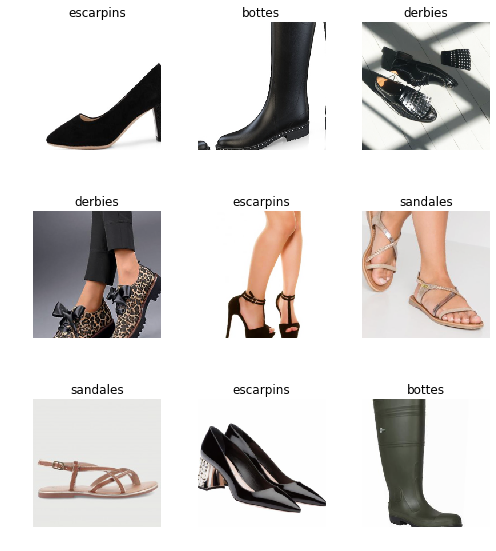

In [27]:
data.show_batch(rows=3, figsize=(7,8))

### Train the model:

So at that point, we can go ahead and create our convolutional neural network using that data. I tend to default to using a resnet34, and let's print out the error rate each time.

In [29]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 111MB/s]


In [30]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.175357,0.823707,0.287500,00:27
1,1.449906,0.641010,0.200000,00:24
2,1.148540,0.589989,0.183333,00:24
3,0.934919,0.593336,0.179167,00:24
4,0.793332,0.595234,0.179167,00:24


In [0]:
learn.save('shoes-stage-1')

As usual, we unfreeze the rest of our model:

In [0]:
learn.unfreeze()

Then we run the learning rate finder and plot it.    
On the learning rate finder, what you are looking for is the strongest downward slope.

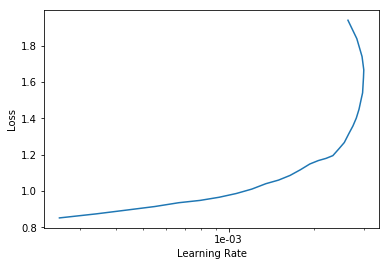

In [33]:
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(4, max_lr=slice(1e-4,1e-3))
# It could have been the following code:
# learn.fit_one_cycle(3, max_lr=slice(3e-4,3e-3))
# That's a rule of thumb﹣it always works pretty well.

epoch,train_loss,valid_loss,error_rate,time
0,0.263921,0.654941,0.162500,00:27
1,0.222516,0.682337,0.162500,00:26
2,0.213471,0.602094,0.145833,00:27
3,0.179673,0.594885,0.141667,00:26


In [0]:
learn.save('shoes-stage-2')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

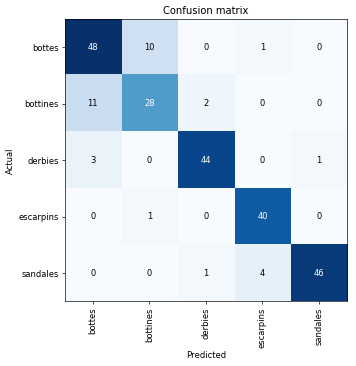

In [38]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

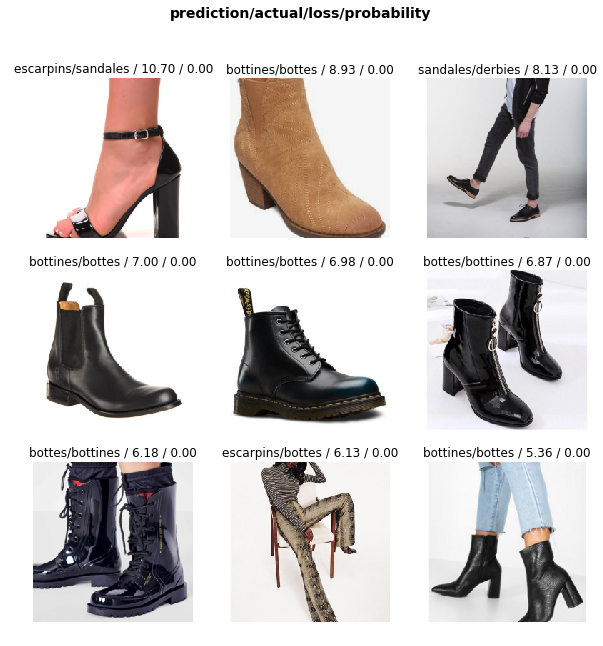

In [39]:
interp.plot_top_losses(9, figsize=(10,10))

In [40]:
interp.most_confused(min_val=2)

[('bottines', 'bottes', 11),
 ('bottes', 'bottines', 10),
 ('sandales', 'escarpins', 4),
 ('derbies', 'bottes', 3),
 ('bottines', 'derbies', 2)]

### Clean up the dataset:

The accuracy is not that good because we are at 86% of accuracy, but given the errors we could see on the confusion matrix or most_confusion, I would say that it still actually very correct.

But possibly you could do even better if your dataset was less noisy. Maybe Google image search didn't give you exactly the right images all the time. So how do we fix that? We want to clean it up. So combining human expert with a computer learner is a really good idea. Very very few people publish on this or teach this, but to me, it's the most useful skill, particularly for you. Most of the people watching this are domain experts, not computer science experts, so this is where you can use your knowledge of point mutations in genomics or Panamanian buses or whatever. So let's see how that would work. What I'm going to do is, do you remember the plot top losses from last time where we saw the images which it was either the most wrong about or the least confident about. We are going to look at those and decide which of those are noisy. If you think about it, it's very unlikely that if there is a mislabeled data that it's going to be predicted correctly and with high confidence. That's really unlikely to happen. So we're going to focus on the ones which the model is saying either it's not confident of or it was confident of and it was wrong about. They are the things which might be **mislabeled**.

A big shout-out to the <u>San Francisco fastai study group</u> who created this new widget this week called the **FileDeleter**. Zach, Jason, and Francisco built this thing where we basically can take the top losses from that interpretation object we just created. There is not just plot_top-losses but there's also top_losses and **top_losses** returns two things: the losses of the things that were the worst and the indexes into the dataset of the things that were the worst. If you don't pass anything at all, it's going to actually return the entire dataset, but sorted so the first things will be the highest losses. Every dataset in fastai has x and y and the **x** contains the things that are used to, in this case, get the <u>images</u>. So this is the image file names and the **y**'s will be the <u>labels</u>. So if we grab the indexes and pass them into the dataset's x, this is going to give us the file names of the dataset ordered by which ones had the highest loss (i.e. which ones it was either confident and wrong about or not confident about). So we can pass that to this new widget that they've created.

Just to clarify, this **top_loss_paths** contains all of the file names in our dataset. When I say "out dataset", this particular one is our validation dataset. So what this is going to do is it's going to clean up mislabeled images or images that shouldn't be there and we're going to remove them from a validation set so that our metrics will be more correct. You then need to rerun these two steps replacing <u>valid_ds</u> with <u>train_ds</u> to clean up your training set to get the noise out of that as well. So it's a good practice to do both. We'll talk about test sets later as well, if you also have a <u>test</u> set, you would then repeat the same thing.

To some up, some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the **ImageCleaner widget** from fastai.widgets or the **FileDeleter widget**, we can <u>prune our top losses</u>, removing photos that don't belong.



In [0]:
from fastai.widgets import *

losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

fd = FileDeleter(file_paths=top_loss_paths)

# NOT WORKING !

In [0]:
from fastai.widgets import *

ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Train)
# ImageRelabeler(ds, idxs)
# Only works when files where labels were created from the names 
# of their parent directory (i.e. with .from_folder())
# or
ImageDeleter(ds, idxs)

# NOT WORKING ! 

Colab does not support widgets from FastAI !!!

So if you are on Jupyter Notebook, follow the steps on this 2 tutorials:
- [Code tutorial for Jupyter Notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb)
- [Detailes tutorial](https://github.com/hiromis/notes/blob/master/Lesson2.md)

Otherwise, on Colab, just follow this notebook:

Let's try an other code that creates a folder "top_losses" with the top_losses files. If we look at those files, we'll see that there are some pictures mislabeled.

In [0]:
from fastai.widgets import *

cleaner_tuples = []
for ds_type in [DatasetType.Valid, DatasetType.Train]:
  ds, idxs = DatasetFormatter().from_toplosses(learn, n_imgs=30, ds_type=ds_type)
  cleaner_tuples.append((ds_type, ds, idxs))

import ntpath

top_loss_path = path/'top_losses/'
top_loss_path.mkdir(parents=True, exist_ok=True)
top_loss_filenames = set()

for ct in cleaner_tuples:
  ds_type = ct[0]
  ds = ct[1]
  idxs = ct[2]

  for idx in idxs:
    full_filepath = ds.x.items[idx]
    _, filename = ntpath.split(full_filepath)
    
    image_data = ds[idx][0]
    image_category = ds[idx][1]
    image_fullpath = top_loss_path/f'{image_category}_{filename}'
    image_data.save(image_fullpath)

Then we can delete files manually.

To have our fulldataset again, without split into train and valid, and with the modifications we operated (some pictures removed):

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [48]:
db

ImageDataBunch;

Train: LabelList (1141 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
sandales,sandales,sandales,sandales,sandales
Path: data/shoes;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/shoes;

Test: None

In [49]:
db.classes, db.c

(['bottes', 'bottines', 'derbies', 'escarpins', 'sandales'], 5)

Let's forget about this db Image Data Bunch that would have been usefull if we could use the commands :  

ds, idxs = DatasetFormatter().from_similars(learn_cln) 
ImageCleaner(ds, idxs, path, duplicates=True).    

But it doesn't work in Colab, remember!    

So let's create a new ImageDataBunch since we deleted some pictures manually after we created the top_losses folder.

But first let's remove the folder top_losses so those images won't be part of our new Image Data Bunch.

In [0]:
!rm -r data/shoes/top_losses
# -r is use to delete the files that are in the folder to,
# without the -r the file won't be deleted because the directory is not empty.

In [0]:
data_cln = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, bs =100, num_workers=20).normalize(imagenet_stats)

In [44]:
data_cln

ImageDataBunch;

Train: LabelList (913 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
sandales,sandales,sandales,sandales,sandales
Path: data/shoes;

Valid: LabelList (228 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bottes,escarpins,derbies,escarpins,escarpins
Path: data/shoes;

Test: None

In [0]:
learn_cln = cnn_learner(data_cln, models.resnet34, metrics=error_rate)

In [46]:
learn_cln2.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.009723,0.524899,0.201754,00:24
1,1.326519,0.426127,0.157895,00:22
2,1.016328,0.466902,0.131579,00:23
3,0.829552,0.446166,0.135965,00:23


In [0]:
learn_cln.save("shoes-cln-stage-1")

In [51]:
learn_cln.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


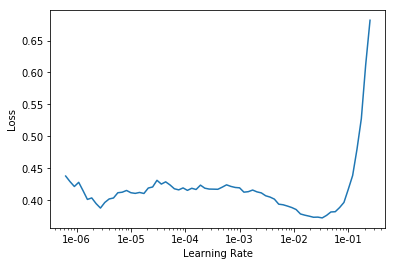

In [52]:
learn_cln.recorder.plot()

In [58]:
learn_cln2.fit_one_cycle(4, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.139695,0.320265,0.092105,00:23
1,0.150195,0.358896,0.092105,00:23
2,0.144430,0.324502,0.083333,00:23
3,0.139904,0.319666,0.092105,00:23


In [0]:
learn_cln.save('shoes-cln-stage-2')

In [0]:
# let's load the previous learn_cln if it appears to be better:
# learn_cln.load('shoes-cln-stage-1')

In [0]:
learn_cln.unfreeze()

In [0]:
interp_cln = ClassificationInterpretation.from_learner(learn_cln)

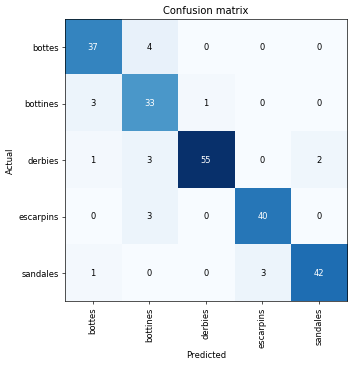

In [63]:
interp_cln.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [64]:
interp_cln.most_confused(min_val=2)

[('bottes', 'bottines', 4),
 ('bottines', 'bottes', 3),
 ('derbies', 'bottines', 3),
 ('escarpins', 'bottines', 3),
 ('sandales', 'escarpins', 3),
 ('derbies', 'sandales', 2)]

223 misclassified samples over 228 samples in the validation set.


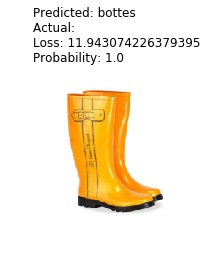

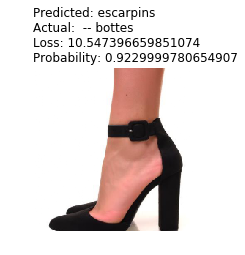

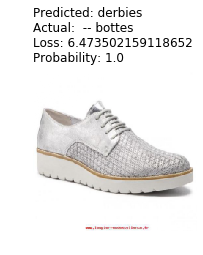

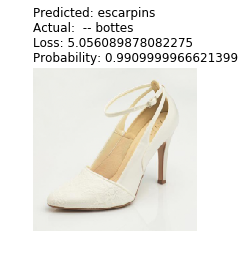

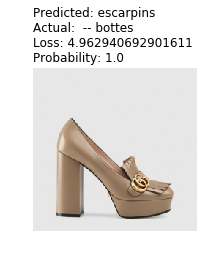

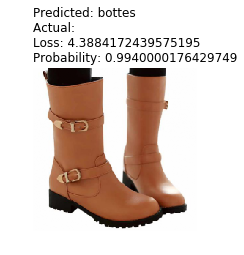

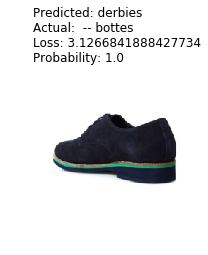

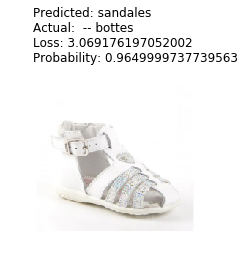

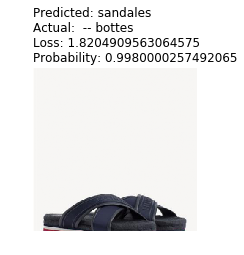

In [65]:
interp_cln.plot_multi_top_losses(9, figsize=(3,3))

Our model learn_cln (actually it is the 3rd loop we made) is really really better, with an accuracy of 91% !

### Put your model in production:

**First thing first, let's export the content of our Learner object for production.**       
This will create a file named '**export.pkl**' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

In [0]:
# First thing first, let's export the content of our Learner object for production:
learn_cln2.export()

Let's create a new folder named "test" to put some images we want to classifie with our model.

In [0]:
path = Path('data/shoes')              # same as before (just to remember)

# creates a new folder "test":
folder = "test"
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

Now I upload manually some photos to test.

As per usual, we created a **data bunch**, but this time, we're not going to create a data bunch from a folder full of images, we're going to create a special kind of data bunch which is one that's going to grab **one single image at a time**. So we're not actually passing it any data. The only reason we pass it a path is so that it knows where to load our model from. That's just the path that's the folder that the model is going to be in.

But what we need to do is that we need to pass it the same information that we trained with. So the same transforms, the same size, the same normalization. This is all stuff we'll learn more about. But just make sure it's the same stuff that you used before.

Now you've got a data bunch that actually doesn't have any data in it at all. It's just something that knows how to transform a new image in the same way that you trained with so that you can now do inference.

You can now create_cnn with this kind of fake data bunch and again, you would use exactly the same model that you trained with. You can now load in those saved weights. So this is the stuff that you only do once﹣just once when your web app is starting up. And it takes 0.1 of a second to run this code.

We create our Learner in production environment.    
Just make sure that path contains the file 'export.pkl' from before.

In [0]:
learning = load_learner(path)

In [0]:
# let's test an image:
img = open_image(path/'test'/'images.jpg')
img1 = open_image(path/'test'/'images_1.jpg')
img2 = open_image(path/'test'/'images_2.jpg')
img3 = open_image(path/'test'/'images_3.jpg')
img4 = open_image(path/'test'/'images_4.jpg')
img5 = open_image(path/'test'/'images_5.jpg')
img6 = open_image(path/'test'/'images_6.jpg')
img7 = open_image(path/'test'/'images_7.jpg')
img8 = open_image(path/'test'/'images_8.jpg')
img9 = open_image(path/'test'/'images_9.jpg')
img10 = open_image(path/'test'/'images_10.jpg')
img11 = open_image(path/'test'/'images_11.jpg')
img12 = open_image(path/'test'/'images_12.jpg')
img13 = open_image(path/'test'/'images_13.jpg')
img14 = open_image(path/'test'/'images_14.jpg')
img15 = open_image(path/'test'/'images_15.jpg')
img16 = open_image(path/'test'/'images_16.jpg')
img17 = open_image(path/'test'/'images_17.jpg')
img18 = open_image(path/'test'/'images_18.jpg')
img19 = open_image(path/'test'/'images_19.jpg')

Then you can make a prediction on your new data:

In [73]:
pred_class,pred_idx,outputs = learning.predict(img)
pred_class

Category sandales

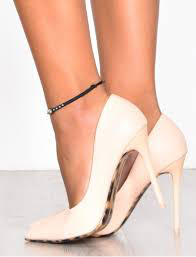

In [74]:
# Let's verify if the picture is really a "sandale"
img

Hum... it's not really a "sandale" but an "escarpins"... Let's try an other image.

escarpins


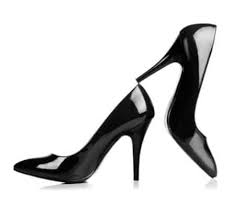

In [76]:
pred_class,pred_idx,outputs = learning.predict(img1)
print(pred_class)
img1

Yeahh ! Good prediction !

escarpins


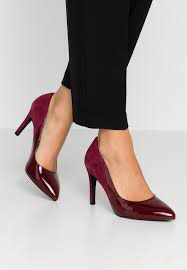

In [77]:
pred_class,pred_idx,outputs = learning.predict(img2)
print(pred_class)
img2

bottines


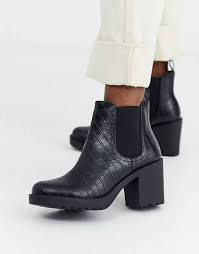

In [78]:
pred_class,pred_idx,outputs = learning.predict(img3)
print(pred_class)
img3

sandales


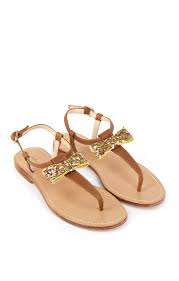

In [79]:
pred_class,pred_idx,outputs = learning.predict(img15)
print(pred_class)
img15

bottes


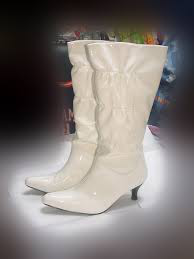

In [80]:
pred_class,pred_idx,outputs = learning.predict(img18)
print(pred_class)
img18

escarpins


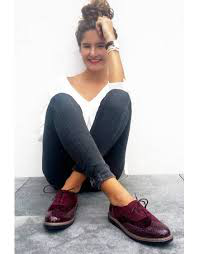

In [82]:
pred_class,pred_idx,outputs = learning.predict(img9)
print(pred_class)
img9